# **PROGETTO DSIM:** *Face emotion recognition*
--------
Mario Pedol (830296),

il task di questo progetto è quello di provare a riconoscere il tipo di espressione dal voto di un individuo. Il dataset a cui si fa rifermento è preso da kaggle al seguente link: https://www.kaggle.com/datasets/deadskull7/fer2013.

A questo fine si sono implementate tecniche diverse di Transfer Learning, presenti e commentate nel presente notebook.


## Envirioment Set UP

Si richiamo tutte le librerire necessarie allo sviluppo dei modelli:

In [2]:
import glob
import shutil
import os
import pandas as pd
from google.colab import drive

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import cv2
import tensorflow as tf 
from tensorflow import keras
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,Input,Dropout,GlobalAveragePooling2D,Flatten,Conv2D,BatchNormalization,Activation,MaxPooling2D
from keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam,SGD,RMSprop
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import vgg16, inception_v3, resnet50
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_input_resnet50
from google.colab import drive
from keras.preprocessing.image import load_img, img_to_array

In [3]:
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


## Sampling Data to run the models

Dopo aver provato ad allenare i modelli con tutti i dati disponibili circa 29000, si è constatato che le risorse computazionali messe a disposizione da colab non fossero sufficienti per complentare in maniera efficace l'adeestramente. Si è quinidi scelto di ridurre il numero di immagini mediante un undersampling casuale per ogni emozione. Si sono eseguite due prove:

1. 5448 immmagini di train, 1311 di validation;
2. 12000 immagini di train, 3111 di validation.

La prima stratgia è stata usata per individuare il modello migliore in tempi ragionevoli (circa 2.30h per addestramento, 1 tentativo al giorno per consumo massimo della GPU). La secondo invece è stata utilizzata per allenare il modello migliore (circa 4.30h per addestramento, 1 tentativo al giorno per consumo massimo della GPU).

Si definisce la funzione di campionamento:

In [ ]:
def random_sampling(index, src_dir=None, dst_dir=None):
  
  for img in os.listdir(src_dir):

    dir = src_dir + str(img) 
    dst = dst_dir + str(img) 

    if(os.path.exists(dst)):
      os.remove(dst)

    if not os.path.isdir(dst): 
      os.makedirs(dst)

    for i, jpgfile in enumerate(glob.iglob(os.path.join(dir, "*.jpg"))):
      if i in index:  
        shutil.copy(jpgfile, dst)

Applicazione del capionamento al train set:

In [ ]:
src_dir = 'gdrive/MyDrive/Progetto_DSIM/Dataset/face_rec/train/' 
dst_dir = 'gdrive/MyDrive/Progetto_DSIM/dati/Dataset/face_rec2/Train/' 

from random import randint

index = []
for _ in range(2000):
	value = randint(0, 4000)
	index.append(value)


random_sampling(index, src_dir=src_dir, dst_dir=dst_dir)


Applicazione del capionamento al validation set:

In [ ]:
src_dir = 'gdrive/MyDrive/Progetto_DSIM/Dataset/face_rec/validation/' 
dst_dir = 'gdrive/MyDrive/Progetto_DSIM/dati/Dataset/face_rec2/Validation/'  

index = []
for _ in range(2000):
	value = randint(0, 4000)
	index.append(value)

random_sampling(index, src_dir=src_dir, dst_dir=dst_dir)

## Data Exploration


Con l'obbiettivo di prendere confidenza con i dati si effetua un analisi esplorativa dei dati:

In [27]:
path_train = 'gdrive/MyDrive/Progetto_DSIM/Dataset/face_rec_sample/train/' 
path_validation ='gdrive/MyDrive/Progetto_DSIM/Dataset/face_rec_sample/validation/'

Prendendo come esempio la prima immagine del train set, espressione "sad", si analizzano le dimensioni e il formato dell'immagine:

In [ ]:
image = cv2.imread('gdrive/MyDrive/Progetto_DSIM/dati/face_rec2/train/sad/3.jpg')

print(type(image))

print('-------')

print('Width:', image.shape[0])
print('Heigth:', image.shape[1])
print('Channels:', image.shape[2])

<class 'numpy.ndarray'>
-------
Width: 48
Heigth: 48
Channels: 3


L'analisi appena condotta mostra che le dimensioni dell'immagini sono 48x48, mentre il numero dei canali è 3.
Si plotta ora per ogni espressione un'immagine:

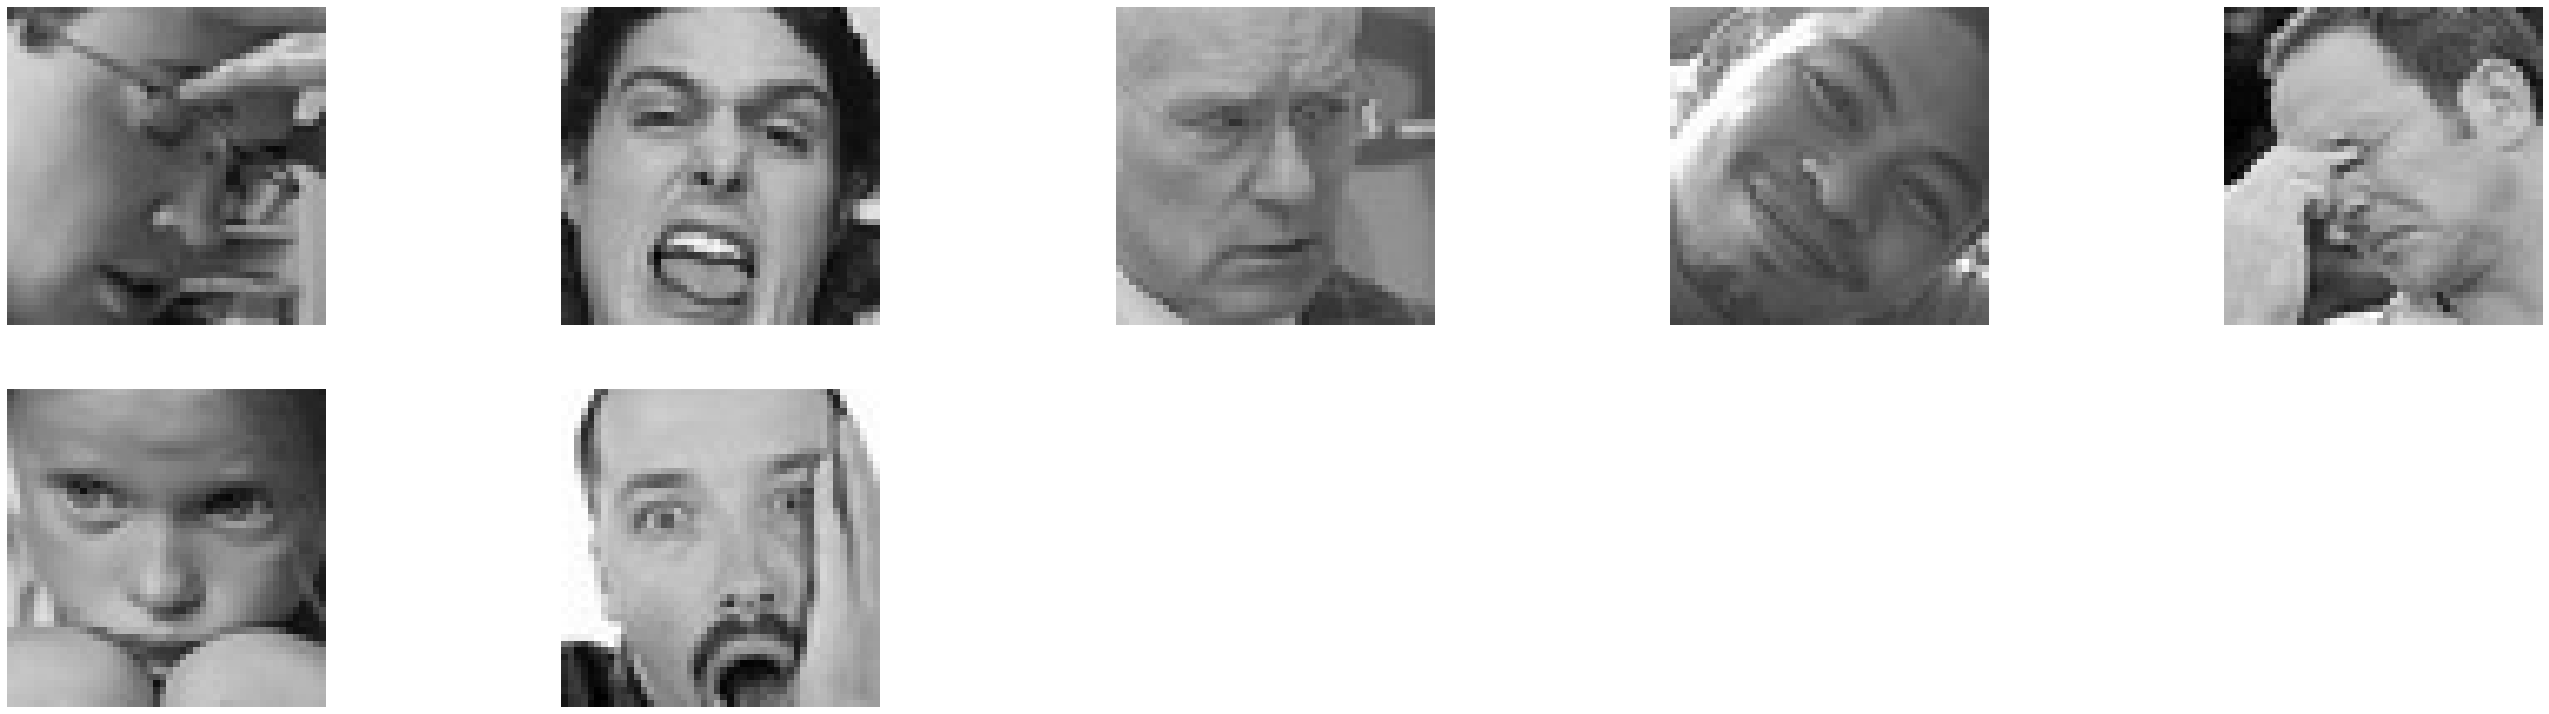

In [ ]:
plt.figure(0, figsize=(48,48))
cpt = 0

for expression in os.listdir(path_train):
    for i in range(1,2):
        cpt = cpt + 1
        sp=plt.subplot(7,5,cpt)
        sp.axis('Off')
        img_path = path_train + expression + "/" +os.listdir(path_train + expression+ "/")[i]
        img = load_img( img_path, target_size=(48,48))
        plt.imshow(img, cmap="gray")


plt.show()

Come si osserva la qulità dell'immagine non è altissima, questo prbabilmente è dovuto alla necessità di rendere il data set più leggero.

Si costruiscono ora due data set per analizzare le differenti distribuzioni delle classi.

In [28]:
df_distribution_train = pd.DataFrame()
for exp in os.listdir(path_train):
    dir = path_train + str(exp) 
    ln = len(os.listdir(dir))
    new = pd.DataFrame({'Expression':[exp], 'n_images':ln})
    df_distribution_train = pd.concat([df_distribution_train,new])

In [29]:
df_distribution_val= pd.DataFrame()
for exp in os.listdir(path_validation):
    dir = path_validation + str(exp) 
    ln = len(os.listdir(dir))
    new = pd.DataFrame({'Expression':[exp], 'n_images':ln})
    df_distribution_val = pd.concat([df_distribution_val,new])

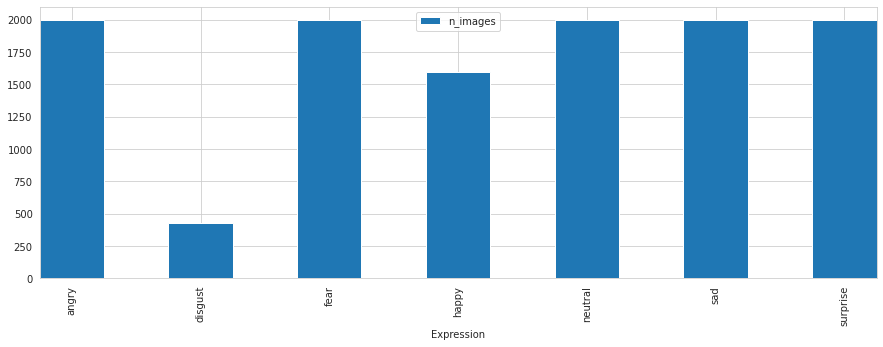

In [30]:
ax = df_distribution_train.plot.bar(x='Expression',y='n_images',figsize=(15, 5))
ax.autoscale(axis='x',tight=True);

dal grafico si nota come le emozioni "happy" e "disgust" siano meno numerose rispetto alle altre. Questo fenomeno sarebbe ancora più accentuato se si considerassero tutte le 28000 immagini. Tuttavia, si è prefirito avere uno sbilaciamento minore e quindi non si sono rispettate perfettamete le proporzioni del dataset originario.

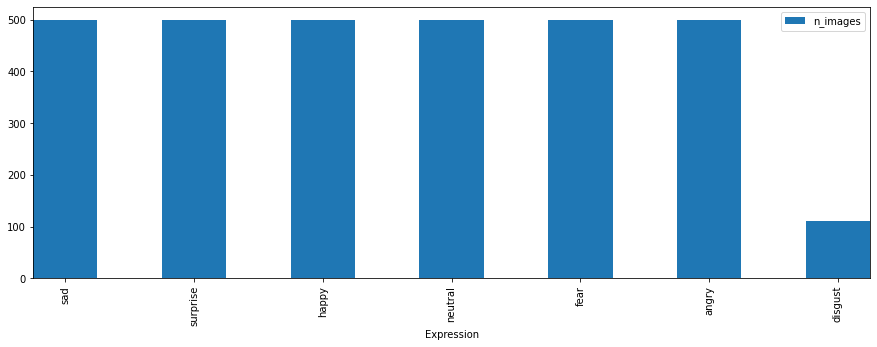

In [ ]:
ax = df_distribution_val.plot.bar(x='Expression',y='n_images',figsize=(15, 5))
ax.autoscale(axis='x',tight=True);

Anche nel validation set non si è testata la stessa numerosità per classe ma è sempre rimasta "disgust" come classe più sbilanciata.

## Preprocessing 

Si preparano i dati per addestrare i modelli. E' importante notare che le immagini sono state riscalate a una dimensione maggiore 224x224, questo è stato fatto per mantenre le dimensioni orginali delle reti preaddestrate utilizzate:

In [5]:
validation_datagen = ImageDataGenerator(rescale=1/255)

batch_size = 128
size=224


train_datagen = ImageDataGenerator(rescale = 1.0/255.0,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   rotation_range = 20,
                                   horizontal_flip = True)

train_generator = train_datagen.flow_from_directory (path_train,   
                                                     target_size=(size, size), 
                                                     batch_size=batch_size,
                                                     shuffle=True,
                                                     class_mode='categorical',
                                                     subset='training',
                                                     color_mode="rgb",
                                                     interpolation='nearest')


validation_generator = validation_datagen.flow_from_directory(path_validation,  
                                                              target_size=(size,size),
                                                              color_mode="rgb",
                                                              batch_size=batch_size,
                                                              class_mode='categorical',
                                                              shuffle=False,
                                                              interpolation='nearest')


Found 5448 images belonging to 7 classes.
Found 1311 images belonging to 7 classes.


## ResNet50 Base

Dopo aver conforntato le reti preaddestrate ResNet50 e MobileNet, si è scelto come rete di transfer il ResNet50.
la prima prova è stata usata su un batch_size piccolo, 64, e un numero di epoche elevato. Il calssificatore in coda è un FFN semplice con uno strato denso di 1024 neuroni e come funzione di attivazione "relu", mentre lo strato di output ha come funzione di attivazione la softmax.

In [ ]:
batch_size = 64
size=224

In [ ]:
base_model = resnet50.ResNet50(
    weights='imagenet',  
    include_top=False, 
    input_shape=(size, size, 3),  
    pooling='avg', 
)

94781440/94765736 [==============================] - 0s 0us/step


In [ ]:
base_model.input_shape

(None, 224, 224, 3)

In [ ]:
x = base_model.output  
x = Dense(1024, activation='relu')(x)  
predictions = Dense(7, activation='softmax')(x) 

In [ ]:
model = Model(inputs=base_model.input, outputs=predictions)

Il metodo di ottimizzazione utilizzato è adam e la funzione di loss da minimizzare è la categorical crossentropy, con metrica di perfomance "accuracy":

In [ ]:
model.compile(
    optimizer='adam', 
    loss="categorical_crossentropy",  
    metrics=['accuracy'])

In [ ]:
history = model.fit_generator(
    generator=train_generator,
    epochs=50,  
    validation_data=validation_generator, 
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/50
59/59 [==============================] - 2858s 48s/step - loss: 1.7830 - accuracy: 0.2846 - val_loss: 470.5245 - val_accuracy: 0.1223
Epoch 2/50
59/59 [==============================] - 127s 2s/step - loss: 1.5631 - accuracy: 0.3234 - val_loss: 2.6455 - val_accuracy: 0.1223
Epoch 3/50
59/59 [==============================] - 127s 2s/step - loss: 1.5093 - accuracy: 0.3646 - val_loss: 1.9297 - val_accuracy: 0.2346
Epoch 4/50
59/59 [==============================] - 127s 2s/step - loss: 1.4853 - accuracy: 0.3899 - val_loss: 1.9459 - val_accuracy: 0.2490
Epoch 5/50
59/59 [==============================] - 127s 2s/step - loss: 1.4515 - accuracy: 0.4008 - val_loss: 1.9857 - val_accuracy: 0.1223
Epoch 6/50
59/59 [==============================] - 128s 2s/step - loss: 1.3865 - accuracy: 0.4360 - val_loss: 2.0499 - val_accuracy: 0.1299
Epoch 7/50
59/59 [==============================] - 127s 2s/step - loss: 1.3463 - accuracy: 0.4474 - val_loss: 6.1936 - val_accuracy: 0.0272
Epoch 8/5

I grafici per un'analisi più completa dei risultati sono stati plottati (per errore cancellati). Questa rete presenta una forte instabilità e overtraining, di conseguenza si è deciso di migliorala modificano la re FFN in coda al modello preaddestrato.

## ResNet50 con regolarizzazione

Una volta individuata la rete di base si passa a migliorare il classificatore, aggiungedo più layer nascosti e degli starti di classificazione DropOut:

In [ ]:
# Setup some constants
batch_size = 64
size=224

In [ ]:
base_model = resnet50.ResNet50(
    weights='imagenet', 
    include_top=False,  
    input_shape=(size, size, 3), 
    pooling='avg',  
)

94781440/94765736 [==============================] - 1s 0us/step


La nuova rete FNN viene così composta:
- Due strati fullyconnect con 2048 e 512 neuroni e funzione di attivazione "relu";
- Strato di DropOut;
- Due strati fullyconnect con 128 e 64 neuroni e funzione di attivazione "relu";
- Strato di DropOut;
- Due strati fullyconnect con 32 e 12 neuroni e funzione di attivazione "relu";
- Strato di output con le 7 classi/neuroni di output e funzione di attivazione "softmax".

In [ ]:
model2 = Sequential()
model2.add(base_model)
model2.add(Dense(2048,'relu'))
model2.add(Dense(512,'relu'))
model2.add(Dropout(.15))
model2.add(Dense(128,'relu'))
model2.add(Dense(64,'relu'))
model2.add(Dropout(.15))
model2.add(Dense(32,'relu'))
model2.add(Dense(16,'relu'))
model2.add(Dense(7,'softmax'))

In [ ]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_7 (Dense)             (None, 2048)              4196352   
                                                                 
 dense_8 (Dense)             (None, 512)               1049088   
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_9 (Dense)             (None, 128)               65664     
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)               

Viene modificato il parametro dell'ottimizzatore adam facendolo partire da un lr alto aggiungendo il callBack "ReduceLROnPlateau", con una tolleranza pari a 3 e un minimo lr di 0.000001

In [ ]:
optimizer = Adam(
    learning_rate=0.001,
)

In [ ]:
model2.compile(
    optimizer=optimizer, 
    loss="categorical_crossentropy",  
    metrics=['accuracy'])

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(
    monitor='accuracy',  
    patience=3,  
    verbose=1, 
    factor=0.2,  
    min_lr=0.000001  
)

In [ ]:
# Fit the model
history = model2.fit_generator(
    generator=train_generator,
    epochs=50,  
    validation_data=validation_generator, 
    callbacks=[learning_rate_reduction]
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/50
43/43 [==============================] - 111s 2s/step - loss: 1.8943 - accuracy: 0.1791 - val_loss: 2.2854 - val_accuracy: 0.1526 - lr: 0.0010
Epoch 2/50
43/43 [==============================] - 86s 2s/step - loss: 1.7469 - accuracy: 0.2474 - val_loss: 2.7695 - val_accuracy: 0.1526 - lr: 0.0010
Epoch 3/50
43/43 [==============================] - 86s 2s/step - loss: 1.6318 - accuracy: 0.3021 - val_loss: 2.3735 - val_accuracy: 0.1526 - lr: 0.0010
Epoch 4/50
43/43 [==============================] - 86s 2s/step - loss: 1.5797 - accuracy: 0.3150 - val_loss: 2.5070 - val_accuracy: 0.1533 - lr: 0.0010
Epoch 5/50
43/43 [==============================] - 87s 2s/step - loss: 1.5483 - accuracy: 0.3275 - val_loss: 2.0586 - val_accuracy: 0.1526 - lr: 0.0010
Epoch 6/50
43/43 [==============================] - 86s 2s/step - loss: 1.5223 - accuracy: 0.3429 - val_loss: 2.0479 - val_accuracy: 0.1526 - lr: 0.0010
Epoch 7/50
43/43 [==============================] - 88s 2s/step - loss: 1.4910 - 

In [ ]:
acc = history.history['accuracy']


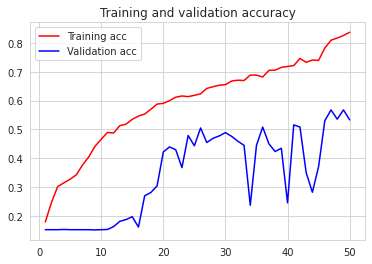

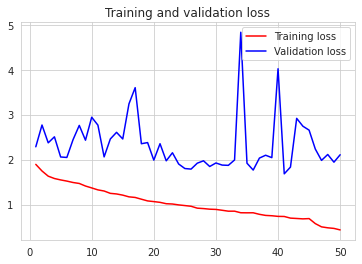

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

sns.set_style("whitegrid")
plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

Dal grafico dell'accuracy si nota che il modello ha ottenuto prestazioni superiori al caso base, val_acc(57%). Si notano dei miglioramenti sulla stabilità della rete che tende a overfittare meno rispetto al caso precedente. Inlotre, il val loss risulta essere ancora molto restando sopra il train loss a conferma dell'overfitting.

In [16]:
import numpy as np
from sklearn.metrics import classification_report

In [ ]:
y_pred = model2.predict(validation_generator)
predicted_categories = np.argmax(y_pred, axis = 1)
true_categories = tf.concat([y for x, y in validation_generator], axis = 0).numpy()
true_categories_argmax = np.argmax(true_categories, axis = 1)


In [ ]:
print(classification_report(true_categories_argmax, predicted_categories))

## Resnet50 con Data Augmentation e regolarizzazzione

Alla luce del caso precedente si aggiunge una nuova regolarizzazzione ossia la data augmentation con i seguenti parametri:

- rotation_range = 25,
- width_shift_range = .2,
- height_shift_range = .2,
- horizontal_flip = True,
- zoom_range = .2


I parametri del modello restano uguali si modifica solo la rete FNN in coda alla rete preaddestrta con l'intento di renderla più semplice e migliorare le performace, trade off tra caso 1 e caso 2.

In [6]:
train_processing = ImageDataGenerator(preprocessing_function = resnet50.preprocess_input,
                                      rotation_range = 25,
                                      width_shift_range = .2,
                                      height_shift_range = .2,
                                      horizontal_flip = True,
                                      zoom_range = .2)



train_generator = train_processing.flow_from_directory (path_train,   
                                                     target_size=(size, size), 
                                                     batch_size=batch_size,
                                                     shuffle=True,
                                                     class_mode='categorical',
                                                     subset='training',
                                                     color_mode="rgb",
                                                     interpolation='nearest')

validation_datagen = ImageDataGenerator(preprocessing_function = resnet50.preprocess_input)

validation_generator = validation_datagen.flow_from_directory(path_validation,  
                                                              target_size=(size,size),
                                                              color_mode="rgb",
                                                              batch_size=batch_size,
                                                              class_mode='categorical',
                                                              shuffle=False,
                                                              interpolation='nearest')

Found 5448 images belonging to 7 classes.
Found 1311 images belonging to 7 classes.


In [7]:
batch_size = 128

In [8]:
base_model = resnet50.ResNet50(
    weights='imagenet',  
    include_top=False, 
    input_shape=(size, size, 3), 
    pooling='avg', 
)

94781440/94765736 [==============================] - 0s 0us/step


la nuova rete è così composta:

- Strato fullyconnect con 1024 neuroni e funzione di attivazione "relu";
- Strato di DropOut;
- Strato di output con le 7 classi/neuroni di output e funzione di attivazione "softmax".

In [9]:
model2 = Sequential()
model2.add(base_model)
model2.add(Dense(2048,'relu'))
model2.add(Dense(512,'relu'))
model2.add(Dropout(.15))
model2.add(Dense(128,'relu'))
model2.add(Dense(64,'relu'))
model2.add(Dropout(.15))
model2.add(Dense(32,'relu'))
model2.add(Dense(16,'relu'))
model2.add(Dense(7,'softmax'))

In [10]:
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 2048)              4196352   
                                                                 
 dense_1 (Dense)             (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               65664     
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0

In [11]:
optimizer = Adam(
    learning_rate=0.0001,
)

In [12]:
model2.compile(
    optimizer=optimizer, 
    loss="categorical_crossentropy",  
    metrics=['accuracy'])

In [13]:
learning_rate_reduction = ReduceLROnPlateau(
    monitor='accuracy',  
    patience=3, 
    verbose=1, 
    factor=0.2,  
    min_lr=0.0000001  
)

In [14]:
history = model2.fit_generator(
    generator=train_generator,
    epochs=30,  # best:13 
    validation_data=validation_generator, 
    callbacks=[learning_rate_reduction]
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/30
43/43 [==============================] - 1441s 33s/step - loss: 1.7521 - accuracy: 0.2504 - val_loss: 2.5219 - val_accuracy: 0.3181 - lr: 1.0000e-04
Epoch 2/30
43/43 [==============================] - 87s 2s/step - loss: 1.5085 - accuracy: 0.4051 - val_loss: 3.4718 - val_accuracy: 0.3028 - lr: 1.0000e-04
Epoch 3/30
43/43 [==============================] - 87s 2s/step - loss: 1.3213 - accuracy: 0.4884 - val_loss: 2.4048 - val_accuracy: 0.3814 - lr: 1.0000e-04
Epoch 4/30
43/43 [==============================] - 87s 2s/step - loss: 1.1702 - accuracy: 0.5477 - val_loss: 2.1462 - val_accuracy: 0.4355 - lr: 1.0000e-04
Epoch 5/30
43/43 [==============================] - 88s 2s/step - loss: 1.1096 - accuracy: 0.5861 - val_loss: 1.9330 - val_accuracy: 0.4966 - lr: 1.0000e-04
Epoch 6/30
43/43 [==============================] - 87s 2s/step - loss: 1.0243 - accuracy: 0.6178 - val_loss: 2.0825 - val_accuracy: 0.5248 - lr: 1.0000e-04
Epoch 7/30
43/43 [==============================] - 87s

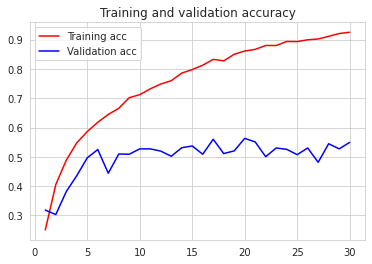

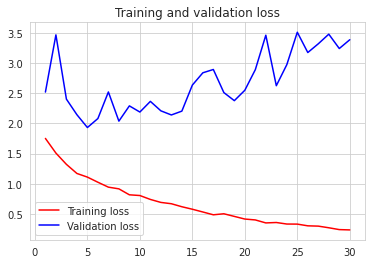

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

sns.set_style("whitegrid")
plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

I risultalti ottenuti non sembrano migliorare la rete di molto rispetto al caso precedente. infatti, l'overfitting risulta più marcato e il val_acc raggiunto resta al (56%). Le curve di Loss invece divergono all'aumentare delle epoche.

## *Final Net ResNet50*

Tenendo in cosiderazioni i casi di tutti i tentativi precedenti, si cerca di estrapolare le parti migliori di ogni tentativo.
Inoltre, viene aumnetato il batch_size a 128, non di più altrimenti colab va in OOM, vengono aumentati i dati di train (caso 2 di campionamento). 

In [ ]:
size=224
batch_size =128 #di più va in OOM

path_train = 'gdrive/MyDrive/Progetto_DSIM/dati/face_rec2/train/'
path_validation ='gdrive/MyDrive/Progetto_DSIM/dati/face_rec2/validation/'


Viene fatta la data augmentation come nel 3 tentativo:

In [ ]:
train_processing = ImageDataGenerator(preprocessing_function = preprocess_input_resnet50,
                                      rotation_range = 25,
                                      width_shift_range = .2,
                                      height_shift_range = .2,
                                      horizontal_flip = True,
                                      zoom_range = .2)



train_generator = train_processing.flow_from_directory (path_train,   
                                                     target_size=(size, size), 
                                                     batch_size=batch_size,
                                                     shuffle=True,
                                                     class_mode='categorical',
                                                     subset='training',
                                                     color_mode="rgb",
                                                     interpolation='nearest')

validation_datagen = ImageDataGenerator(preprocessing_function = preprocess_input_resnet50)

validation_generator = validation_datagen.flow_from_directory(path_validation,  
                                                              target_size=(size,size),
                                                              color_mode="rgb",
                                                              batch_size=batch_size,
                                                              class_mode='categorical',
                                                              shuffle=False,
                                                              interpolation='nearest')

Found 12031 images belonging to 7 classes.
Found 3111 images belonging to 7 classes.


In [ ]:
base_model = resnet50.ResNet50(
    weights='imagenet',  
    include_top=False,  
    input_shape=(size, size, 3),  
    pooling='avg', 
)

94781440/94765736 [==============================] - 1s 0us/step


Viene utilizzata la rete FNN del 2 tentativo ritenuta la più stabile:

In [ ]:
model2 = Sequential()
model2.add(base_model)
model2.add(Dense(2048,'relu'))
model2.add(Dense(512,'relu'))
model2.add(Dropout(.15))
model2.add(Dense(128,'relu'))
model2.add(Dense(64,'relu'))
model2.add(Dropout(.15))
model2.add(Dense(32,'relu'))
model2.add(Dense(16,'relu'))
model2.add(Dense(7,'softmax'))

In [ ]:
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 2048)              4196352   
                                                                 
 dense_1 (Dense)             (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               65664     
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0

Non viene utilizzato nessun callBacks, non se ne vista la necessità visto che nel secondo tentativo non è stata utilizzato neanche se inserita:

In [ ]:
model2.compile(
    optimizer='adam', 
    loss="categorical_crossentropy",  
    metrics=['accuracy'])

Le epoche sono state diminuite a 30 per tempo massimo di utilizzo della GPU:

In [ ]:
history = model2.fit_generator(
    generator=train_generator,
    epochs=30,   #26
    validation_data=validation_generator)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


Epoch 1/30
94/94 [==============================] - 3056s 32s/step - loss: 1.8962 - accuracy: 0.1682 - val_loss: 1.9429 - val_accuracy: 0.1662
Epoch 2/30
94/94 [==============================] - 191s 2s/step - loss: 1.8790 - accuracy: 0.1829 - val_loss: 2.0294 - val_accuracy: 0.1643
Epoch 3/30
94/94 [==============================] - 191s 2s/step - loss: 1.8231 - accuracy: 0.2361 - val_loss: 15.9199 - val_accuracy: 0.1607
Epoch 4/30
94/94 [==============================] - 191s 2s/step - loss: 1.7409 - accuracy: 0.2785 - val_loss: 5.8519 - val_accuracy: 0.1633
Epoch 5/30
94/94 [==============================] - 190s 2s/step - loss: 1.7014 - accuracy: 0.2996 - val_loss: 1.8481 - val_accuracy: 0.2565
Epoch 6/30
94/94 [==============================] - 191s 2s/step - loss: 1.6618 - accuracy: 0.3271 - val_loss: 2.5837 - val_accuracy: 0.1896
Epoch 7/30
94/94 [==============================] - 193s 2s/step - loss: 1.6162 - accuracy: 0.3498 - val_loss: 2.5821 - val_accuracy: 0.2835
Epoch 8/30

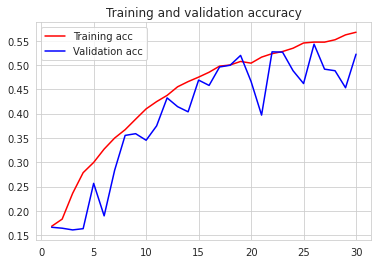

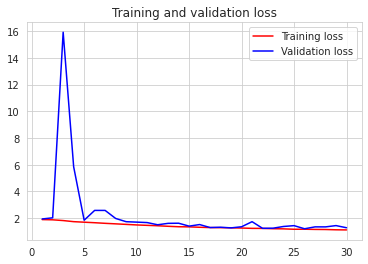

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

sns.set_style("whitegrid")
plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

I risultati trovati sono soddisfacienti, la rete infatti si è stabilizzata abbstanza, l'overfitting sull'accuracy si è molto ridotto, come si può osservare anche dalle curve di loss. Il valore val acc raggiunto è 56% (lanciando la stessa rete più volte il massimo raggiunto è stato 59%).

La rete risulta essere la migliore e dunque viene salvata e utlizzata per la demo:

In [ ]:
import pickle
filename = 'FaceRecBest.sav'
pickle.dump(model2, open(filename, 'wb'))


INFO:tensorflow:Assets written to: ram://f939d0b2-e1da-45e3-bf9c-b8728a3453ca/assets


In [ ]:
!cp FaceRecBest.sav 'gdrive/MyDrive/Progetto_DSIM/codici/Face_rec/FaceRecBest.sav'